# Files and versioning

Unless you are a string theorist, at some point you're probably going to want to save and load some data. This tutorial covers some of Sciris' tools for doing that more easily.

<div class="alert alert-info">
    
Click [here](https://mybinder.org/v2/gh/sciris/sciris/HEAD?labpath=docs%2Ftutorials%2Ftut_files.ipynb) to open an interactive version of this notebook.

</div>


<div class="alert alert-warning">
    <b>Warning!</b> The tools here are powerful, which also makes them dangerous. Unless it's in a simple text format like JSON or CSV, loading a datafile can run arbitrary code on your computer, just like running a Python script can. If you wouldn't run a Python file from some source, don't open a data file from that source either.
</div>

## Saving and loading literally anything

Let's assume you're mostly just saving and loading files you've created yourself or from trusted colleagues, not opening email attachments from the branch of the local mafia. Then everything here is absolutely fine.

Let's revisit our sim from the first tutorial:

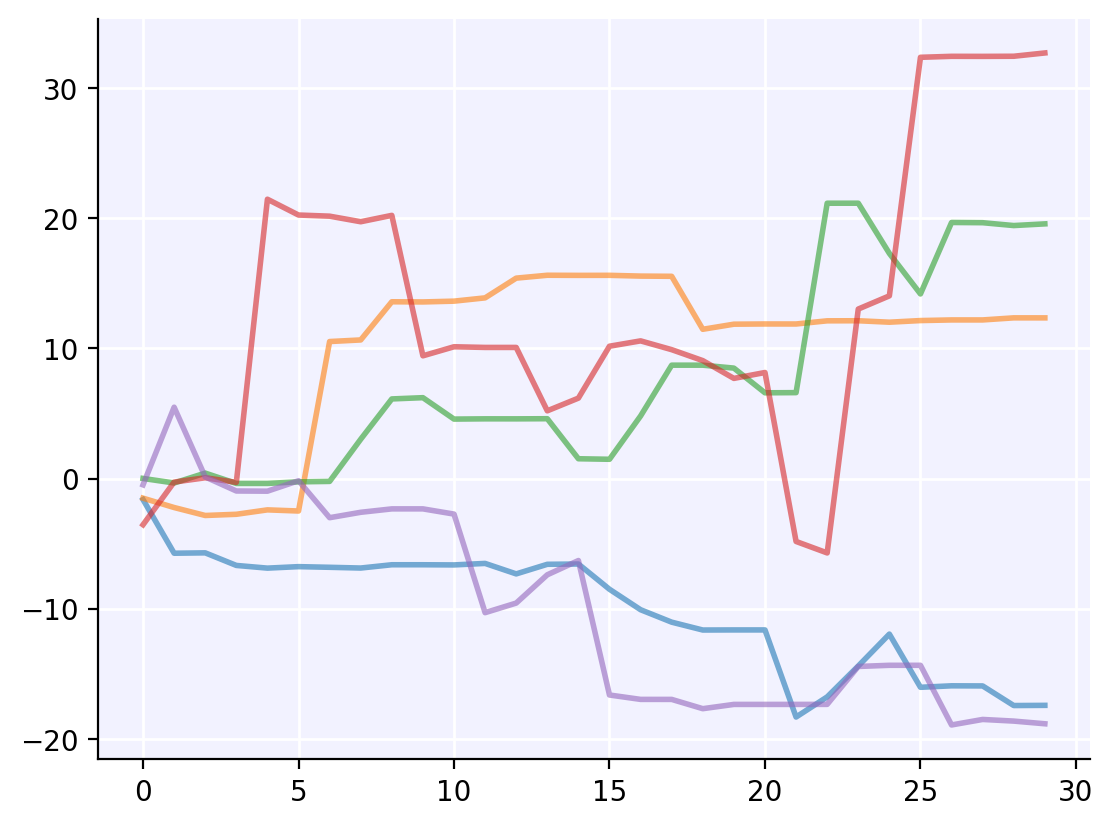

In [1]:
import sciris as sc
import numpy as np
import pylab as pl
sc.options(jupyter=True) # To make plots nicer

class Sim:
    
    def __init__(self, days, trials):
        self.days = days
        self.trials = trials
    
    def run(self):
        self.x = np.arange(self.days)
        self.y = np.cumsum(np.random.randn(self.days, self.trials)**3, axis=0)
    
    def plot(self):
        with pl.style.context('sciris.fancy'):
            pl.plot(self.x, self.y, alpha=0.6)

# Run and save
sim = Sim(days=30, trials=5)
sim.run()
sc.save('my-sim.obj', sim) # Save any Python object to disk

# Load and plot
new_sim = sc.load('my-sim.obj') # Load any Python object
new_sim.plot()

We can create a sim (which of course doesn't have to be a sim, it can be absolutely any object), then reload it from disk and it works just like new – even calling methods works! What's happening here? Under the hood, `sc.save()` saves the object as a [gzipped](https://docs.python.org/3/library/gzip.html) (compressed) [pickle]](https://docs.python.org/3/library/pickle.html) (byte stream). Pickles are how Python sends objects internally, so can handle almost anything. (For the few corner cases that `pickle` can't handle, `sc.save()` falls back on [dill](https://dill.readthedocs.io/en/latest/), which really can handle everything.) 

There are also other compression options than gzip ([zstandard](https://python-zstandard.readthedocs.io/en/latest/) or no compression), but you probably don't need to worry about these. (If you _really_ care about performance, then `sc.zsave()`, which uses `zstandard` by default, is slightly faster than `sc.save()` – but regardless of how a file was saved you can load it with `sc.load()`.

## Saving and loading JSON and YAML

While `sc.save()` and `sc.load()` are great for many things, they _aren't_ great for just sharing data. First, they're not compatible with anything other than Sciris, so if you try to share one of those files with, say, an R user, they won't be able to open them. 

If you just have data and don't want to save the objects, you should save just the data. If you want to save to CSV or Excel (i.e., data that looks like a spreadsheet), you should convert it to a dataframe (`df = sc.dataframe(data)`), then save it from there (`df.to_excel()` and `df.to_csv()`, respectively). 

But if you want to save data that's a little more complex, you should consider JSON: it's fast, it's easy for humans to read, and absolutely everything loads it. While typically a JSON maps onto a Python `dict`, Sciris will take pretty much any object and save out the JSONifiable parts of it:

In [5]:
# Try saving our sim as a JSON
sc.savejson('my-sim.json', sim)

# Load it as a JSON
sim_json = sc.loadjson('my-sim.json')
print(sim_json)

{'python_class': "<class '__main__.Sim'>", 'days': 30, 'trials': 5, 'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 'y': [[-1.613712283154746, -1.5062892104406806, 0.008268713835614217, -3.545864926235845, -0.4834616822788357], [-5.733899089308542, -2.2242567546435743, -0.3399554359736384, -0.2689662010968621, 5.481323145861254], [-5.7049604625251025, -2.8353067020259966, 0.4195164004625529, 0.06062774718178515, 0.12418437763252754], [-6.671146280809915, -2.7431472133179575, -0.37355219798410777, -0.2916296410118366, -0.9544611403222871], [-6.878100043414671, -2.4041302110171996, -0.37325747040300367, 21.452961064991115, -0.9691671922923769], [-6.764306453921497, -2.491677311074477, -0.25175880495850955, 20.239040030199988, -0.16604090762368562], [-6.8147307274664115, 10.523219422089142, -0.21840149037047693, 20.151199922993325, -3.0049798470877405], [-6.871379730712871, 10.645847060728714, 3.0210692417137883, 19.7237

It's not exactly beautiful, and it's not as powerful as `sc.save()` (for example, `sim_json.plot()` doesn't exist), but it has all the _data_, exactly as it was laid out in the original object:

In [13]:
print(f"{sim_json['x'] = }")
print(f"{sim_json['y'][0] = }")

sim_json['x'] = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
sim_json['y'][0] = [-1.613712283154746, -1.5062892104406806, 0.008268713835614217, -3.545864926235845, -0.4834616822788357]


(Note that when exported to JSON and loaded back again, everything is in default Python types – so the data is now a list of lists rather than a 2D Numpy array.)

If you're not super familiar with [YAML](https://yaml.org/), you might think of it as that quirky config file format with lots of colons and indents. It _is_ that, but it's also a powerful extension to JSON – every JSON file is also a valid YAML file, but the reverse is not true (i.e., JSON is a subset of YAML). Of most interest to you, dear scientist, is that you can add comments to YAML files. Consider this (relatively) common situation:

In [22]:
raw_json = '''
{"variables": {
    "timepoints": [0,1,2,3,4,5],
    "really_important_variable": 12.566370614359172
  }
}
'''
data = sc.readjson(raw_json)
print(data)

{'variables': {'timepoints': [0, 1, 2, 3, 4, 5], 'really_important_variable': 12.566370614359172}}


Now you're tearing your hair out. Where did 12.566370614359172? It looks vaguely familiar, or at least it did to the you from 6 months ago who wrote it. But with YAML, you can have your data and comment it too:

In [23]:
raw_yaml = '''
{"variables": {
    "timepoints": [0,1,2,3,4,5],
    "really_important_variable": 12.566370614359172 # This is just 4π lol
  }
}
'''
data = sc.readyaml(raw_yaml)
print(data)

{'variables': {'timepoints': [0, 1, 2, 3, 4, 5], 'really_important_variable': 12.566370614359172}}


## Other file functions

Sciris includes a number of other file utilities. For example, to get a list of files, you can use `sc.getfilelist()`:

In [25]:
sc.getfilelist('*.ipynb')

['tut_advanced.ipynb',
 'tut_arrays.ipynb',
 'tut_dates.ipynb',
 'tut_dicts.ipynb',
 'tut_files.ipynb',
 'tut_intro.ipynb',
 'tut_parallel.ipynb',
 'tut_plotting.ipynb',
 'tut_printing.ipynb',
 'tut_utils.ipynb']

Sometimes it's useful to get the folder for the current file, since sometimes you're calling it from a different place, and want the relative paths to remain the same (for example, to load something from a subfolder):

In [27]:
sc.thispath()

PosixPath('/tmp/ipykernel_797628')

(This looks wonky here because this notebook is run on some random cloud server, but it should look more normal if you do it at home!)

Most Sciris file functions can return either strings or [Paths](https://docs.python.org/3/library/pathlib.html). If you've never used `pathlib`, it's a really powerful way of handling paths. But it's also really intuitive. For example, to create a `data` subfolder that's always relative to this notebook regardless of where it's run from, you can do

In [34]:
datafolder = sc.thispath() / 'data'
print(datafolder)

/tmp/ipykernel_797628/data


(Note: 

In [31]:
import os
# os.chdir(sc.thispath())
# datafolder = sc.thispath() / 'data'
# print(datafolder)
dir()

['In',
 'Out',
 'Sim',
 '_',
 '_16',
 '_24',
 '_25',
 '_26',
 '_27',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_dh',
 '_i',
 '_i1',
 '_i10',
 '_i11',
 '_i12',
 '_i13',
 '_i14',
 '_i15',
 '_i16',
 '_i17',
 '_i18',
 '_i19',
 '_i2',
 '_i20',
 '_i21',
 '_i22',
 '_i23',
 '_i24',
 '_i25',
 '_i26',
 '_i27',
 '_i28',
 '_i29',
 '_i3',
 '_i30',
 '_i31',
 '_i4',
 '_i5',
 '_i6',
 '_i7',
 '_i8',
 '_i9',
 '_ih',
 '_ii',
 '_iii',
 '_oh',
 'data',
 'datafolder',
 'exit',
 'get_ipython',
 'json',
 'new_sim',
 'np',
 'open',
 'os',
 'pl',
 'quit',
 'raw_json',
 'raw_yaml',
 'sc',
 'sim',
 'sim_json']

In [33]:
__package__